# Watts-Strogatz

In this notebook we compute the minimal and loose homological scaffolds of a Watts-Strogatz (weighted) random graph. We follow the framework of (__[Sizemore, Giusti, Bassett: Classification of weighted networks through mesoscale homological features. Journal of Complex Network (2017)](https://doi.org/10.1093/comnet/cnw013)__)

Libraries

In [1]:
# source files are two folders above
import sys
sys.path.append('../../src')

import Driver
import Geometry
import Scaffold

import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pk

sys.path.append('../../')
import Holes as ho

Set the parameters for the Watts-Strogatz model (__[ref](https://doi.org/10.1093/comnet/cnw013)__). To build a weighted Watts-Strogatz random graph, we follow the approach in the paper, illustrated __[here](https://sites.google.com/a/seas.upenn.edu/weighted-network-toolbox/network-construction)__. <br>
As per the choice of parameters, the paper uses $83$ nodes, with a stub count of $50$, and a rewiring probability of $0,025$. We have repeated the analysis with several different combinations, the choice below being made for speed of visualization.

In [4]:
# Set the parameters
NV = 35
k = 15
p = 0.025

# Create the ring lattice
A = np.zeros( (NV,NV))
for i in range(NV):
    for j in range(k//2):
        j+=1
        tj = (i+j)%NV
        d = min(j, np.abs(i-tj))
        A[i , tj] = 1/d if d!=0 else 0


#np.reciprocal(A,out=A,where=A[A!=0])
A = 0.5*(A + A.transpose())

# Now rewire
def pick_new(row,i):
    zr = np.nonzero(row == 0)
    zr = zr[0]
    zr = np.setdiff1d(zr,np.array(i))
    if len(zr) == 0:
        raise ValueError
    ind = np.random.choice(zr)
    return ind

for i in range(NV):
    for j in range(i,NV):
        if (A[i,j] != 0 and np.random.random() < p ):
            try:
                node = pick_new(A[i,:],i)              
                A[i,node] = A[i,j]
                A[node,i] = A[i,j]
                A[i,j] = 0
                A[j,i] = 0
            except:
                pass

From the adjacency matrix build the graph, and draw it.

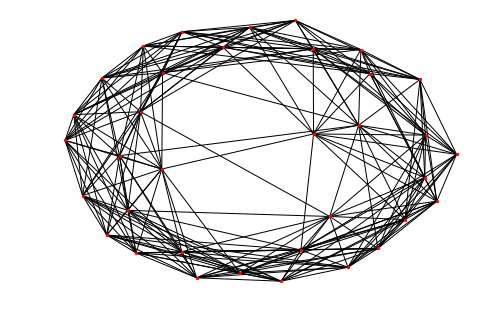

In [5]:
G = nx.from_numpy_matrix(A,parallel_edges=False)
layout = nx.layout.spring_layout(G)
nx.draw(G, pos=layout, node_size=5)

### Reading
In case one already has a given weighted graph to work with, one can read it from disk. <br>
Uncomment if necessary.

In [6]:
#A = pk.load(open('<path to file>','rb'))
#G = nx.from_numpy_matrix(A,parallel_edges=False)

### Paths

In [11]:
basedir = '../..'
#scriptdir = basedir + '<path to here>'
scriptdir = './'

## Holes
Compute the scaffold

In [12]:
#COMPUTE THE UPWARD FILTRATION
fil = ho.filtrations.upward_limited_weight_clique_rank_filtration(G,max_clique_dim=3)
clique_dictionary_file = scriptdir + 'WSFiltration.pck'
pk.dump(fil,open(clique_dictionary_file,'wb'), protocol=2)

hom_dim = 1 # max homology group calculated
dataset_tag = 'test_ws'
output_dir = scriptdir

ho.persistent_homology_calculation(clique_dictionary_file, hom_dim, dataset_tag, output_dir,m1=512, m2=2048,save_generators=True)


Preliminary scan of edge weights to define filtration steps...
Constructing filtration...
Max filtration value: 6
Clique dictionary created.
Calling: jython  ../../Holes/jython_utils/persistent_homology_calculation.py ./WSFiltration.pck 1 ./ test_ws_ /Users/marco/javaplex/ True
0


Child returned 0


Write the generators to disk

In [13]:
gen_file = scriptdir + 'gen/generators_test_ws_.pck'
gen = pk.load(open(gen_file, 'rb'))

ScafH = nx.Graph()
ScafH.add_nodes_from(G)

edges = []

for c in gen[1]:
    edges.extend(c.cycles())
    
for e in edges:
    u , v = int(e[0]) , int(e[1])
    if ScafH.has_edge(u,v):
        ScafH[u][v]['weight'] += 1
    else:
        ScafH.add_edge(u, v, weight=1)

#WRITE RESULTING SCAFFOLD TO FILE        
out_file = scriptdir + 'Scaffolds/JPScaffold.pck'
pk.dump(ScafH, open(out_file,'wb'))

Then draw the resulting homological scaffold

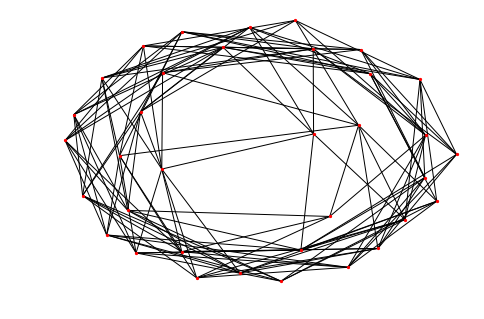

In [14]:
nx.draw(ScafH, pos = layout, node_size=5)

## Minimal Scaffold
Now compute the minimal scaffold

In [15]:
# get the filtration
epsList = Geometry.genFullEpsList(A) 

out_file = scriptdir + 'monitor'

# Compute the minimal generators
Filtr = Driver.getFiltrBasis(A, epsList, Draws=False, parallel=False, monitor=out_file)

Write the generators to disk

In [16]:
filtr_out = scriptdir + 'gen/MinFiltr.pck'
pk.dump(Filtr, open(filtr_out,'wb'))

Now compute the minimal scaffold

In [17]:
# From the filtration compute the scaffold
S = Scaffold.frequency_Scaffold(Filtr , NV)
Scaf = nx.from_numpy_matrix(S, parallel_edges=False)

# Write the scaffold
out_file = scriptdir + 'Scaffolds/MinScaffold.pck'
pk.dump(Scaf, open(out_file,'wb'))

Finally, draw the result

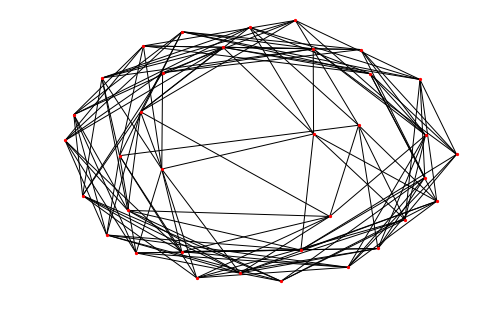

In [18]:
nx.draw(Scaf, pos = layout, node_size=5)